In [1]:
import pandas as pd 
import numpy as np
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVR
import xgboost as xgb
MAX_TOWERS = 6
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import random

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_absolute_error
from scipy.sparse import hstack 
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
import math
from collections import defaultdict
from utils import get_test, get_train
from ensemble import Ensembler
from utils import clean_non_targeted
%load_ext line_profiler

/anaconda2/envs/env/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
from utils import get_test, get_train
from pipelines import common_pipeline, train_hook, target_hook, \
    cont_pipeline, cat_pipeline, null_cat_step, text_pipeline, date_pipeline
from cleaner import DataCleaner

dc = DataCleaner(common_pipelines=common_pipeline, column_pipelines=[
    cont_pipeline, null_cat_step, cat_pipeline, text_pipeline, date_pipeline],
                 train_hooks=train_hook, target_hooks=target_hook)

X_train, X_test, y_train, groups = dc.get_clean_data(get_train(), get_test(), group_col="Скважина")
X_train, groups, y_train = clean_non_targeted([X_train, groups], y_train)

Main shape (3357, 123)
0 duplicates
396 duplicates
242 duplicates
final shape (3357, 153)
Main shape (266, 114)
0 duplicates
53 duplicates
66 duplicates
final shape (266, 144)
after hooks
(3357, 153)
(266, 144)
Нефть, т dropped
{'Станок-качалка', 'Фирма ГРП', 'Тип газосепаратора', 'Примечание', 'Агент закачки'} dropped
['ТП(ИДН) Дебит жидкости скорр-ый', 'ТП(ГРП) Дебит жидкости', 'ТП(ГРП) Дебит жидкости скорр-ый', 'ГП - Общий прирост Qн', 'Жидкость, м3', 'Нефть, м3', 'Дебит жидкости', 'ТП(ИДН) Дебит жидкости'] dropped
After common_pipeline
(3357, 139)
(266, 139)


/Users/kkushaev/PycharmProjects/gp_oil/src/pipelines.py:367: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  train[c] = train[c].astype(str)
/Users/kkushaev/PycharmProjects/gp_oil/src/pipelines.py:368: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  test[c] = test[c].astype(str)
/Users/kkushaev/PycharmProjects/gp_oil/src/pipelines.py:383: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

nans in column pipelines
False
shape_after_column_pipelines
(3357, 741)
(266, 741)
(2493, 741)
(2493,)
(2493,)


In [3]:
def get_df_from_posts(X_pos,Y_pos, X, y):
    return X.loc[X_pos], y.loc[Y_pos]
        

def getXY_for_step(X,y, groups, group_col_prefix="pos_number_"):
    X_stepped = {}
    y_stepped = {}
    comb = pd.concat([X, groups], axis=1)
    groups_by_skw = comb.groupby(groups.name)
    indexes_X = defaultdict(list)
    indexes_y = defaultdict(list)
    for name, group in groups_by_skw:
        for i in range(6):
            next_item_idx = group[group["pos_number_%s"%i]==1].index
            if len(next_item_idx)>0:
                indexes_X[i].append(group.index[0])
                indexes_y[i].append(next_item_idx[0])
    for i in range(6):
        X_step, y_step = get_df_from_posts(indexes_X[i], indexes_y[i], X, y)
        X_stepped[i] = X_step
        y_stepped[i] = y_step
        print("step %s : %s total"%(i,len(X_step)))
    return X_stepped, y_stepped

In [4]:
def get_preds(X_step, y_step, X_test):
    preds = []
    for i in range(6):
        x = X_step[i]
        y = y_step[i]
        ensem = Ensembler()
        ensem.fit(x,y)
        preds.append(ensem.predict(X_test))
    return np.hstack(preds)

In [5]:
def get_prediction(X_train, y_train, X_groups, X_test, constant = 701.4750):
    X_step, y_step = getXY_for_step(X_train, y_train, X_groups)
    preds = get_preds(X_step, y_step, X_test)
    return preds+(constant- np.mean(preds))

In [6]:
def create_submission(fname, df):
    final_pred = pd.Series(df)
    final_pred.to_csv(fname,header=["_VAL_"],index_label=["_ID_"])

In [7]:
def transform_train_into_test(X_train,y_train,group):
    comb = pd.concat([X_train, group], axis=1)
    X_test = comb.groupby(group.name).head(1)
    
    comb_y = pd.concat([y_train, group], axis=1)
    preds = []
    for name, grp in comb_y.groupby(group.name):
        cur = grp[y_train.name].values
        preds.extend(cur)
        to_full = 6 - len(cur)
        for i in range(to_full):
            preds.append(0)
        
    return X_test.drop([group.name],axis=1), pd.Series(preds, name = y_train.name)

In [8]:

from sklearn.model_selection import GroupKFold
def cross_validate(train, y, groups,n_folds = 5):
    errors = []
    k_fold = GroupKFold(n_splits=n_folds)
    for tr_ix, test_ix in k_fold.split(train,y, groups=groups):
        print("new fold started")
        train_x = train.iloc[tr_ix]
        test_x = train.iloc[test_ix]
        
        train_y = y.iloc[tr_ix]
        test_y = y.iloc[test_ix]
        
        train_groups = groups.iloc[tr_ix]
        test_groups = groups.iloc[test_ix]
        
        constant = np.mean(test_y)
        test_x, test_y = transform_train_into_test(test_x, test_y, test_groups)
        print("train "+str(train_x.shape)+":"+str(train_y.shape))
        print("test "+str(test_x.shape)+":"+str(test_y.shape))
        print("groups"+str(train_groups.shape)+":"+str(test_groups.shape))
        test_preds = get_prediction(train_x, train_y, train_groups, test_x, constant=constant)
        null_mask = test_y==0
        test_y = test_y[~null_mask]
        test_preds = test_preds.ravel()[~null_mask]
        error=mean_absolute_error(y_true=test_y, y_pred=test_preds)
        print("fold error:%s" % error)
        errors.append(error)
    print("overall error: %s" % np.mean(errors))
    print(errors)

In [9]:
cross_validate(X_train, y_train, groups)

new fold started
train (1994, 741):(1994,)
test (95, 741):(570,)
groups(1994,):(499,)
step 0 : 195 total
step 1 : 358 total
step 2 : 352 total
step 3 : 366 total
step 4 : 365 total
step 5 : 358 total
fold error:556.1596958172249
new fold started
train (1994, 741):(1994,)
test (95, 741):(570,)
groups(1994,):(499,)
step 0 : 194 total
step 1 : 355 total
step 2 : 354 total
step 3 : 367 total
step 4 : 366 total
step 5 : 358 total
fold error:597.4128493356036
new fold started
train (1994, 741):(1994,)
test (95, 741):(570,)
groups(1994,):(499,)
step 0 : 190 total
step 1 : 356 total
step 2 : 354 total
step 3 : 367 total
step 4 : 367 total
step 5 : 360 total
fold error:534.0947767060458
new fold started
train (1995, 741):(1995,)
test (94, 741):(564,)
groups(1995,):(498,)
step 0 : 194 total
step 1 : 356 total
step 2 : 354 total
step 3 : 367 total
step 4 : 365 total
step 5 : 359 total
fold error:594.0610632364817
new fold started
train (1995, 741):(1995,)
test (94, 741):(564,)
groups(1995,):(498,

In [ ]:
overall error: 586.8529780351473 - no tuning at all

In [381]:
from sklearn.metrics.pairwise import cosine_similarity
def get_most_similar(x1,x2):
    matr = cosine_similarity(x1,x2)
    return np.argmax(matr, axis = 0)

similar_to_test  = get_most_similar(X_train,X_test)
similar_to_test

array([ 935, 3556, 1145, 2288, 8105, 8106,  893,  893, 6388, 4998, 8159,
       6303, 4854, 4472, 3457, 8159, 4125, 3667, 1161, 3596, 8159, 4728,
       4728, 3310, 3310, 6894, 4664, 7538, 3271, 3272, 6894, 3392, 2260,
       4998, 5550, 4854, 4854, 3170, 8687, 6388, 3383, 3383, 1173, 2918,
       3577, 4394, 3554, 6119, 3805, 3805, 1229, 1230, 4397, 3595, 4397,
       2690, 4362, 6390, 1550, 1550, 1550, 1550, 1551, 1551, 1551, 1551,
       7226, 7226, 5154, 3793, 8651, 2618, 3596, 1251, 4854,  629, 6422,
       6279, 1147, 3170, 3383, 2132, 4123, 4124, 4125, 1145, 5172, 5154,
       8687, 6939, 5963, 2132, 2288, 5694, 5695, 5696, 5697, 7879, 4728,
       4728, 1891, 1391, 7538,  300,  300, 7130, 4125, 4125, 2691, 5000,
       3170, 1145, 2216, 5026, 5154, 5000, 5000,  581, 3595, 7685, 6388,
       6388, 3691, 7957, 4746, 4746,  221, 6939, 3383, 8159,  935, 1389,
       8651, 6388, 4394, 3457, 3457, 1121, 1121, 1121, 5526, 6279, 4728,
       3595, 6387, 6881, 6881, 6881, 7681, 2438, 56

In [382]:
target_group = group.loc[similar_to_test]
target_group = target_groups.values.ravel()
test_sim_idx = group[group.isin(target_group).values]

In [383]:
true_test = pd.concat([X_train.loc[test_sim_idx.index]], axis=1)

/anaconda2/envs/env/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':


In [373]:
X_sim_train = X_train.drop(index=true_test.index)
y_sim_train = Y.drop(index=true_test.index)

In [11]:
gkf = list(GroupKFold(n_splits=4).split(X_train, y_train, groups=groups))

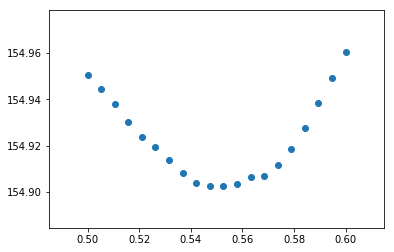

In [20]:

scores =[]
for a in np.linspace(0.5, 0.6, 20):
    scores.append(np.mean(-cross_val_score(Lasso(alpha=a),X_train, y_train, n_jobs=-1, 
                                   scoring="neg_mean_absolute_error", cv=gkf)))
plt.scatter(np.linspace(0.5, 0.6, 20),scores)

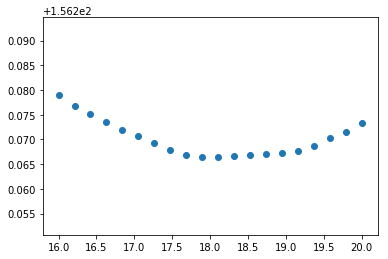

In [26]:

scores =[]
for a in np.linspace(16, 20, 20):
    scores.append(np.mean(-cross_val_score(Ridge(alpha=a),X_train, y_train, n_jobs=-1, 
                                   scoring="neg_mean_absolute_error", cv=gkf)))
plt.scatter(np.linspace(16, 20, 20),scores)

In [ ]:

scores =[]
for a in np.linspace(16, 20, 20):
    scores.append(np.mean(-cross_val_score(,X_train, y_train, n_jobs=-1, 
                                   scoring="neg_mean_absolute_error", cv=gkf)))
plt.scatter(np.linspace(16, 20, 20),scores)

In [ ]:
from sklearn.grid_search import GridSearchCV
# Set the parameters by cross-validation
tuned_parameters = {'n_estimators': [100, 300, 500], 'max_depth': [None, 1, 2, 3], 'min_samples_split': [2, 3, 4]}

# clf = ensemble.RandomForestRegressor(n_estimators=500, n_jobs=1, verbose=1)
clf = GridSearchCV(RandomForestRegressor(criterion="mae"), tuned_parameters, cv=gkf, scoring="neg_mean_absolute_error", n_jobs=-1, verbose=1)
clf.fit(X_train, y_train)
print(clf.best_estimator_)


Fitting 4 folds for each of 36 candidates, totalling 144 fits


In [ ]:
from sklearn.grid_search import GridSearchCV
# Set the parameters by cross-validation
tuned_parameters = {'n_estimators': [100, 300, 500], 'max_depth': [None, 1, 2, 3], 'learning_rate': [0.01, 0.05, 0.1]}

# clf = ensemble.RandomForestRegressor(n_estimators=500, n_jobs=1, verbose=1)
clf = GridSearchCV(xgb.XGBRegressor(), tuned_parameters, cv=gkf, scoring="neg_mean_absolute_error", n_jobs=-1, verbose=1)
clf.fit(X_train, y_train)
print(clf.best_estimator_)
